In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, auc)

# Load the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
columns = ['Status_of_existing_checking_account', 'Duration_in_month', 'Credit_history', 'Purpose', 
           'Credit_amount', 'Savings_account/bonds', 'Present_employment_since', 'Installment_rate_in_percentage_of_disposable_income', 
           'Personal_status_and_sex', 'Other_debtors/guarantors', 'Present_residence_since', 'Property', 
           'Age_in_years', 'Other_installment_plans', 'Housing', 'Number_of_existing_credits_at_this_bank', 
           'Job', 'Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone', 'foreign_worker', 'Good_Loan']

data = pd.read_csv(url, sep=' ', header=None, names=columns)
data['Good_Loan'] = data['Good_Loan'] - 1  # Adjust target to 0 and 1


In [4]:
# Initial exploration
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   Status_of_existing_checking_account                       1000 non-null   object
 1   Duration_in_month                                         1000 non-null   int64 
 2   Credit_history                                            1000 non-null   object
 3   Purpose                                                   1000 non-null   object
 4   Credit_amount                                             1000 non-null   int64 
 5   Savings_account/bonds                                     1000 non-null   object
 6   Present_employment_since                                  1000 non-null   object
 7   Installment_rate_in_percentage_of_disposable_income       1000 non-null   int64 
 8   Personal_status_and_sex      

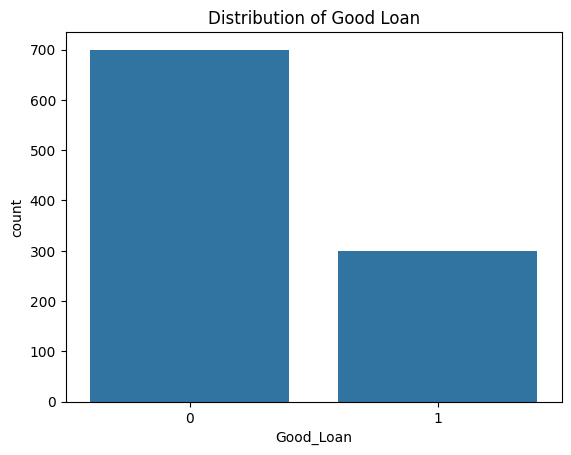

In [5]:
# Distribution of the target variable
sns.countplot(x='Good_Loan', data=data)
plt.title('Distribution of Good Loan')
plt.show()

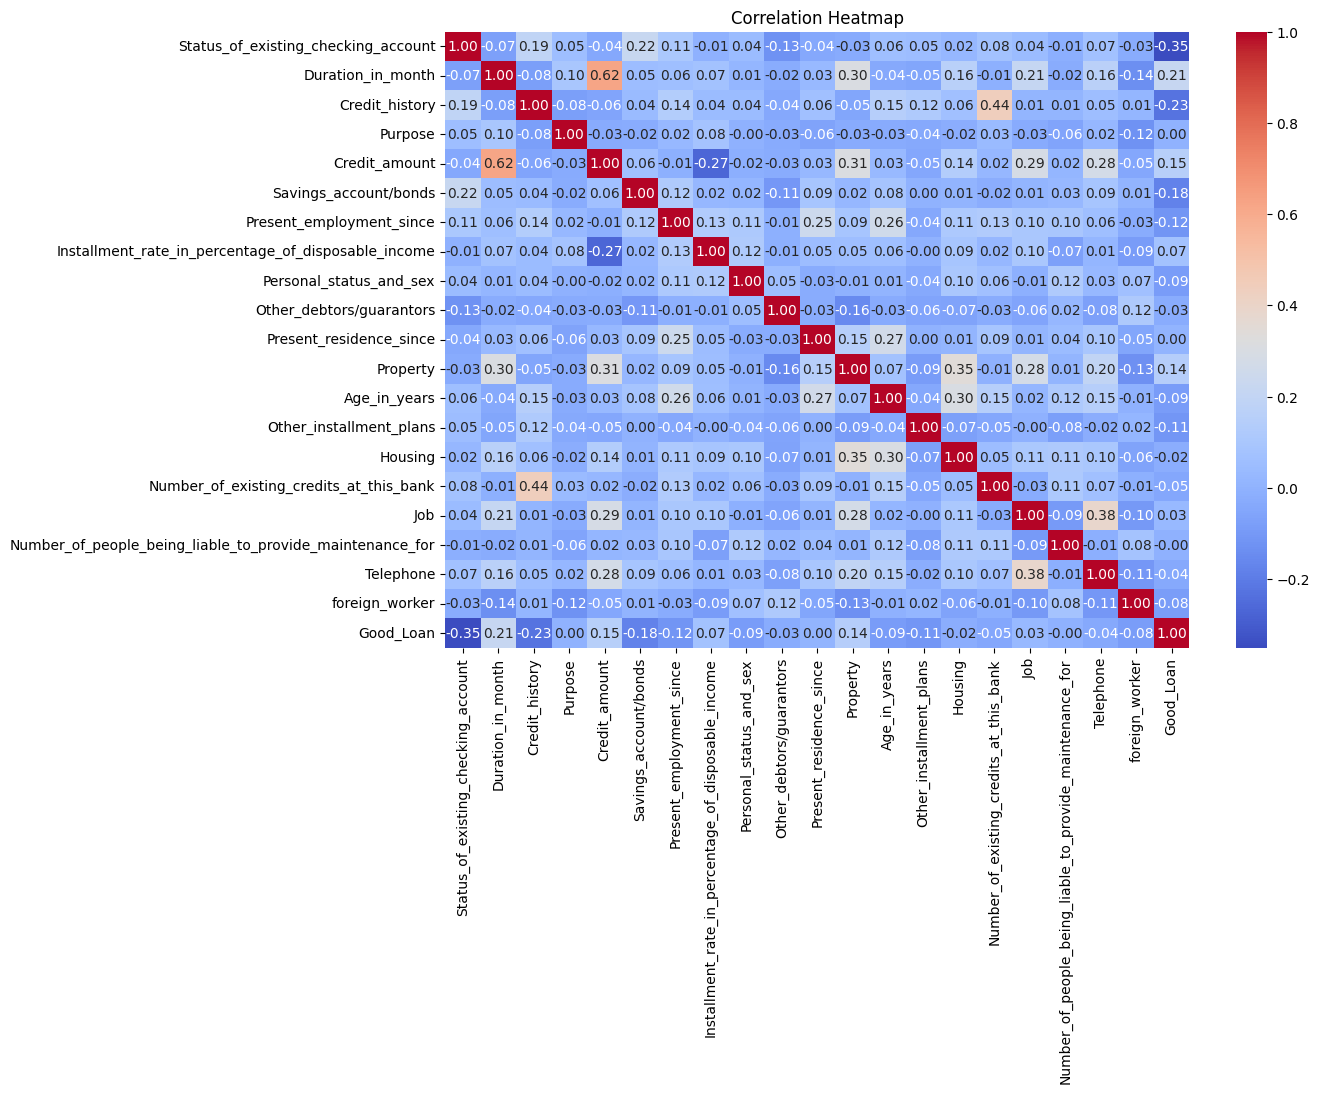

In [8]:
# Encode categorical variables
label_encoders = {}
for column in data.columns:
    if data[column].dtype == 'object':
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [9]:
# Encode categorical variables
label_encoders = {}
for column in data.columns:
    if data[column].dtype == 'object':
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le

# Split the data
X = data.drop('Good_Loan', axis=1)
y = data['Good_Loan']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [10]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10],
    'criterion': ['gini', 'entropy']
}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
print(f'Best parameters: {grid_search.best_params_}')


Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\ksham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 300}


In [11]:
# Predicting on the test set
y_pred = best_rf_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.77
Precision: 0.71
Recall: 0.37
F1 Score: 0.49
Confusion Matrix:
[[132   9]
 [ 37  22]]


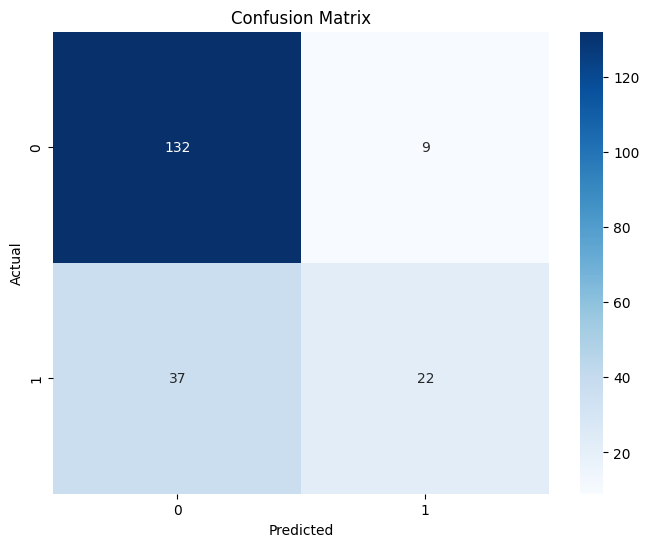

In [12]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

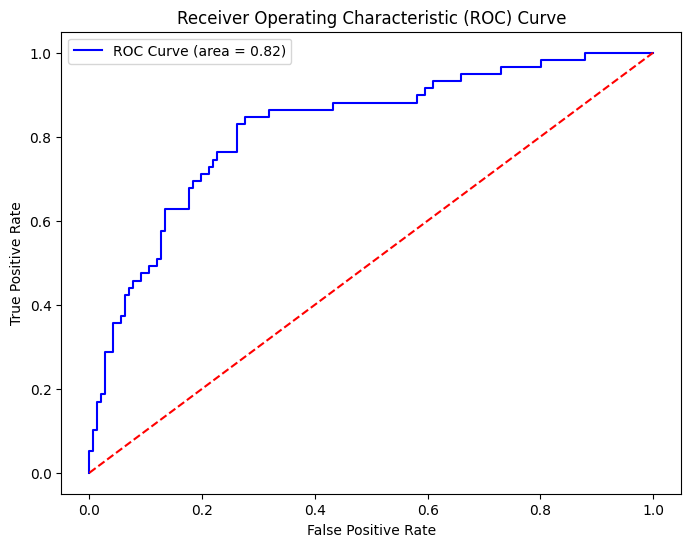

In [13]:
# ROC curve
y_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

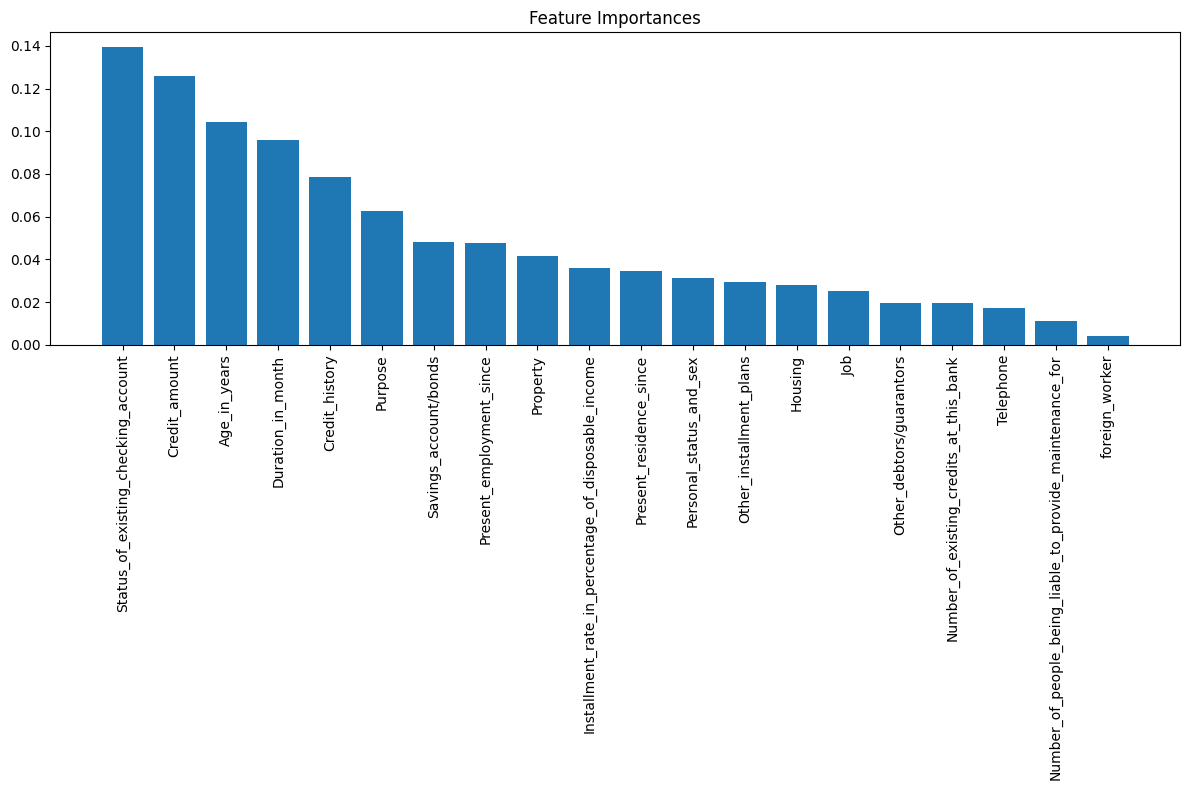

In [14]:
# Feature importance
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()